#  <center> Speech Emotion Recognition <center>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music.

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation


In [2]:
# Paths for data.
Ravdess = "dataset/RAVDESS/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,dataset/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,dataset/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,dataset/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,dataset/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,calm,dataset/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav


In [4]:
# creating Dataframe 
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,dataset/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,dataset/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,dataset/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,dataset/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,calm,dataset/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav


## Data Visualisation and Exploration

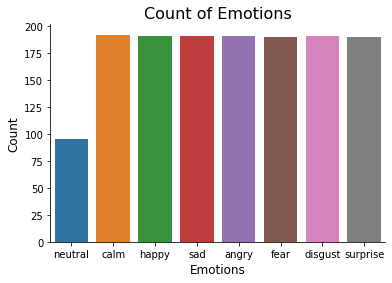

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

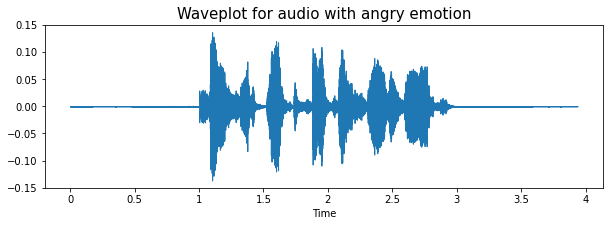

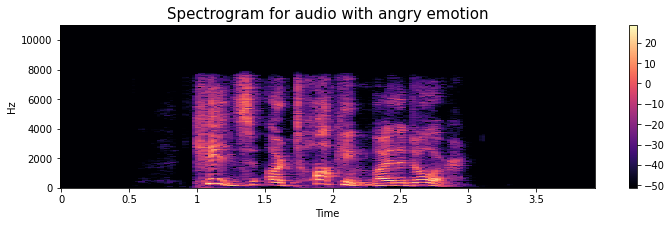

In [7]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

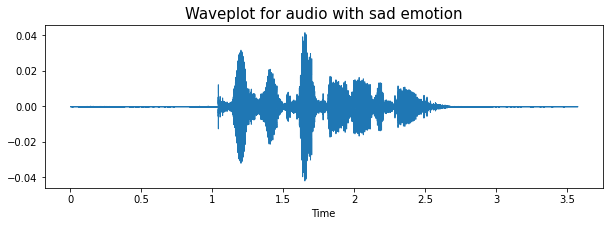

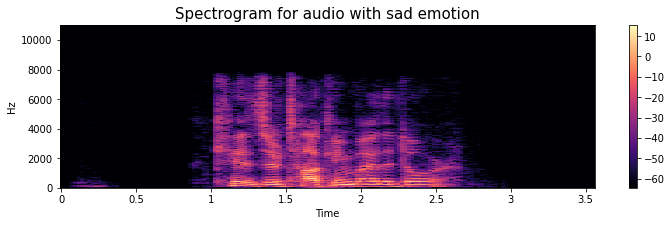

In [8]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

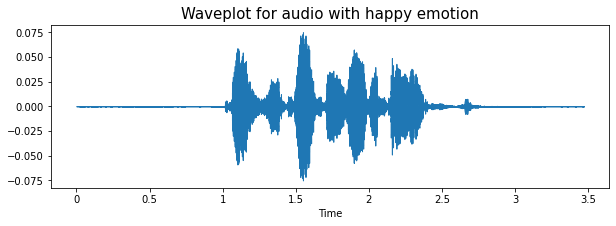

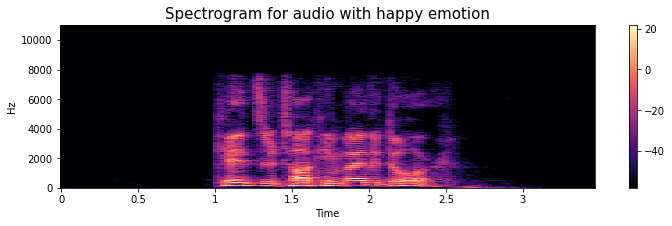

In [9]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

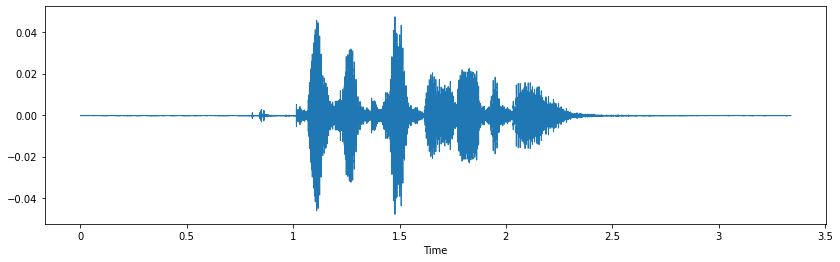

In [11]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

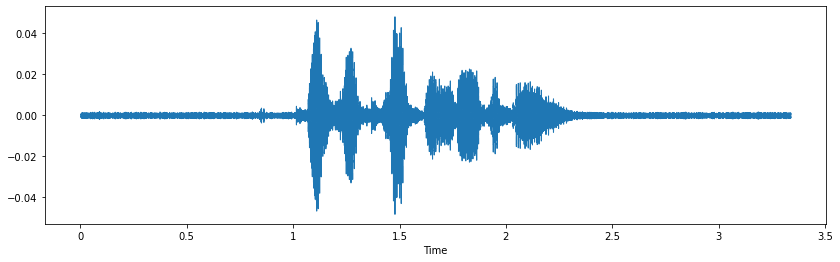

In [12]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

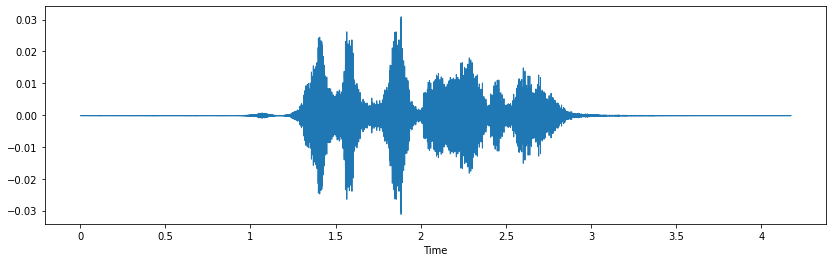

In [13]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

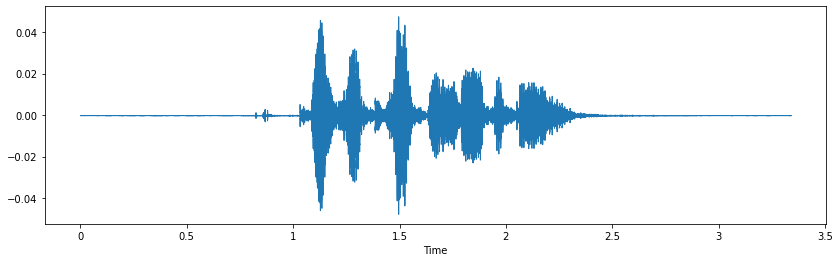

In [14]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

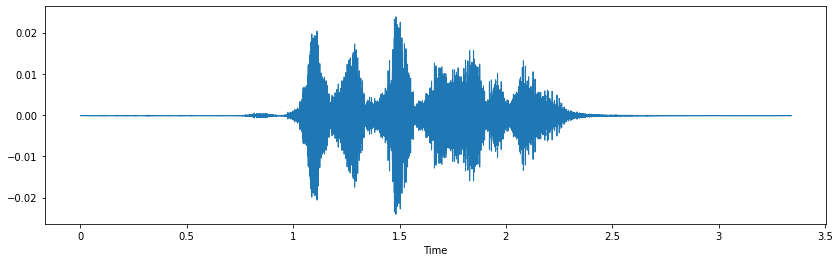

In [15]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

In [16]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))    
    return result

def get_features(path):
    
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) 
    
    return result

In [17]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [18]:
len(X), len(Y), data_path.Path.shape

(4293, 4293, (1431,))

In [19]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237707,0.659623,0.688045,0.660470,0.668179,0.691457,0.679695,0.700933,0.743595,0.777434,...,1.456007e-16,1.230215e-16,1.155918e-16,1.210945e-16,1.205286e-16,1.039733e-16,1.046511e-16,1.092856e-16,9.492505e-17,neutral
1,0.317098,0.815552,0.807240,0.802609,0.816281,0.784295,0.669182,0.686509,0.734595,0.757050,...,5.750720e-05,5.843793e-05,6.037782e-05,6.342009e-05,6.104224e-05,6.085230e-05,5.904421e-05,6.277858e-05,6.112134e-05,neutral
2,0.172588,0.578456,0.658056,0.670302,0.626939,0.618905,0.680813,0.665565,0.687514,0.707852,...,8.388324e-13,8.413657e-13,7.065617e-13,6.980500e-13,6.658314e-13,6.671515e-13,6.032135e-13,6.223830e-13,6.326584e-13,neutral
3,0.207284,0.650128,0.689902,0.661357,0.645668,0.683536,0.684938,0.679724,0.732556,0.756279,...,9.362391e-17,1.017879e-16,8.988047e-17,9.321179e-17,9.068552e-17,9.977286e-17,8.490875e-17,8.585167e-17,9.594947e-17,neutral
4,0.280617,0.739819,0.779045,0.757905,0.740329,0.756131,0.684143,0.648848,0.699067,0.740266,...,7.724802e-06,8.005219e-06,7.853950e-06,8.302643e-06,7.945306e-06,7.720930e-06,7.811414e-06,8.212757e-06,7.656064e-06,neutral


In [20]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [21]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [22]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3219, 162), (3219, 8), (1074, 162), (1074, 8))

In [23]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3219, 162), (3219, 8), (1074, 162), (1074, 8))

In [24]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3219, 162, 1), (3219, 8), (1074, 162, 1), (1074, 8))

## Modelling

In [25]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [26]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 29s 506ms/step - loss: 1.9943 - accuracy: 0.1985 - val_loss: 1.9084 - val_accuracy: 0.2561 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 24s 477ms/step - loss: 1.9194 - accuracy: 0.2364 - val_loss: 1.8407 - val_accuracy: 0.2384 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 24s 474ms/step - loss: 1.8498 - accuracy: 0.2634 - val_loss: 1.7815 - val_accuracy: 0.3101 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 26s 509ms/step - loss: 1.7942 - accuracy: 0.2880 - val_loss: 1.7480 - val_accuracy: 0.3138 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 24s 472ms/step - loss: 1.7513 - accuracy: 0.3175 - val_loss: 1.6495 - val_accuracy: 0.3724 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 23s 449ms/step - loss: 1.7001 - accuracy: 0.3399 - val_loss: 1.6673 - val_accuracy: 0.3724 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 23s 448ms/st

34/34 [==============================] - 2s 64ms/step - loss: 1.3532 - accuracy: 0.6276
Accuracy of our model on test data :  62.75604963302612 %


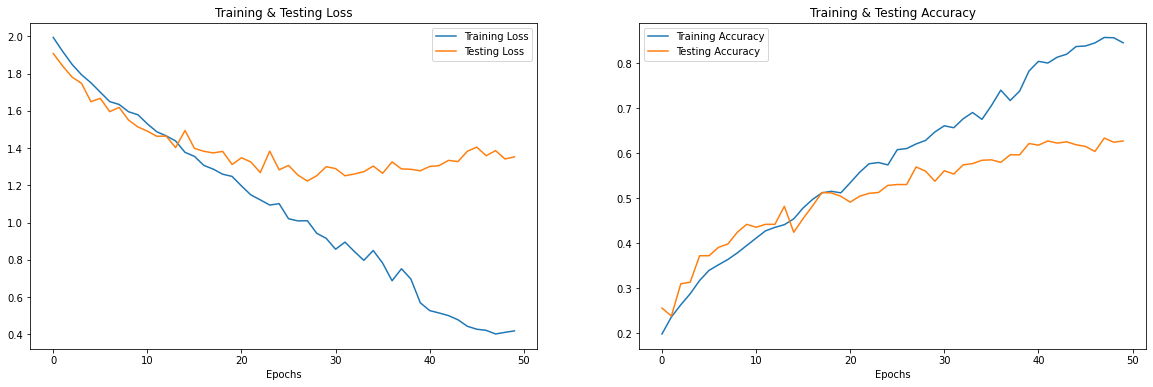

In [27]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [28]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [29]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,surprise
1,sad,happy
2,happy,happy
3,calm,calm
4,happy,fear
5,happy,happy
6,happy,angry
7,disgust,disgust
8,surprise,surprise
9,disgust,disgust


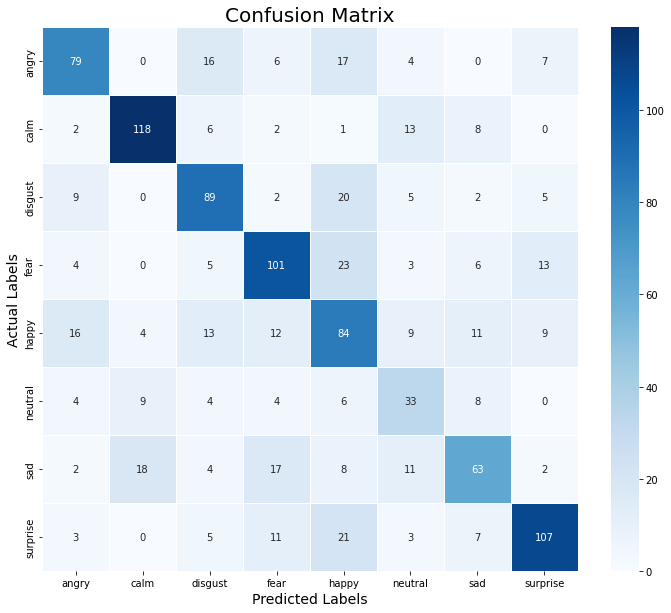

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.66      0.61      0.64       129
        calm       0.79      0.79      0.79       150
     disgust       0.63      0.67      0.65       132
        fear       0.65      0.65      0.65       155
       happy       0.47      0.53      0.50       158
     neutral       0.41      0.49      0.44        68
         sad       0.60      0.50      0.55       125
    surprise       0.75      0.68      0.71       157

    accuracy                           0.63      1074
   macro avg       0.62      0.62      0.62      1074
weighted avg       0.64      0.63      0.63      1074



In [33]:
model.save("Emotion_model.h5")